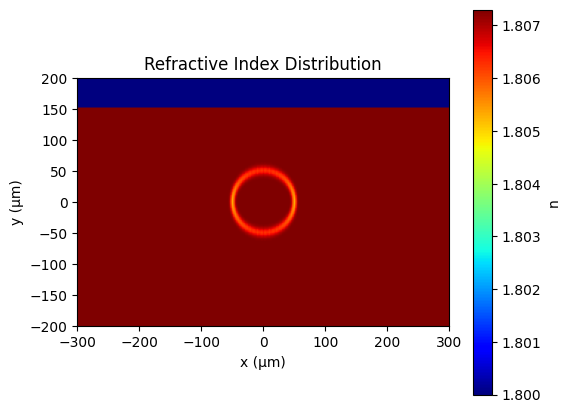

  0%|          | 0/1000 [00:00<?, ?it/s]

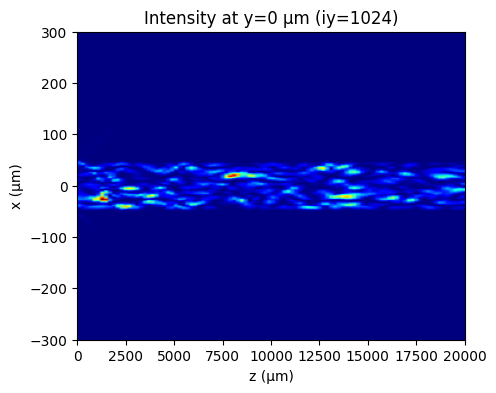

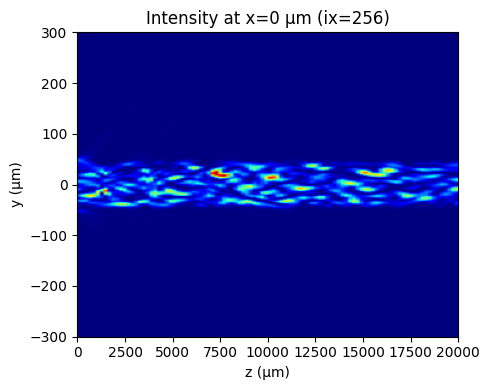

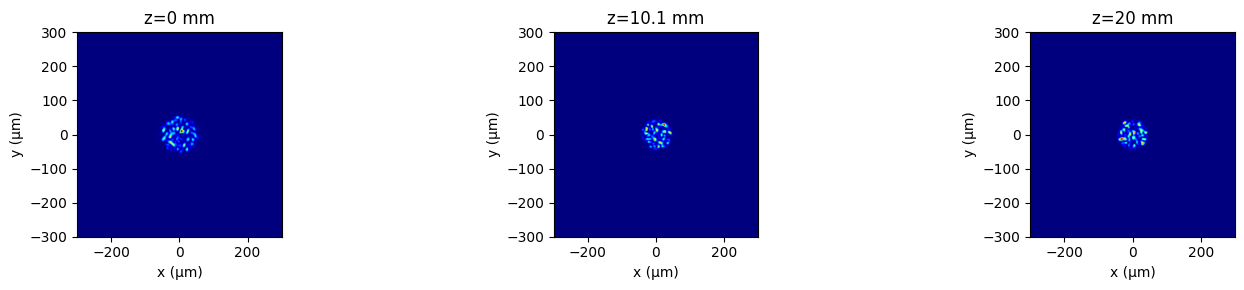

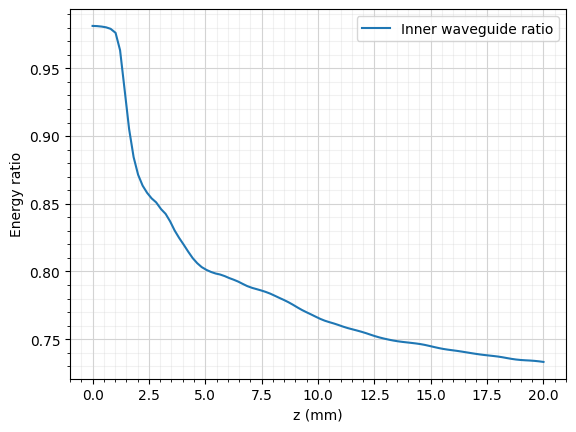

GIF saved to /media/kobayashilab/raid10ssd/akiyamay/BPM_github/p_dn=-0.001_div=50_WGr=0.0001_waist=5.25e-05/my_profile_animation.gif



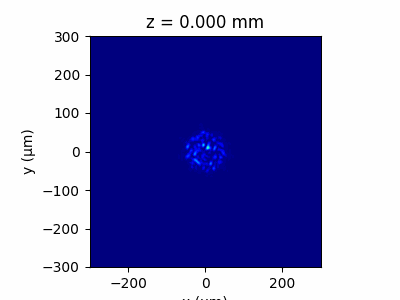

In [ ]:
import os
import pdb
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import io
import imageio
from PIL import Image
from IPython.display import HTML, display
from pathlib import Path
from collections import namedtuple
from torch.fft import fft2, ifft2, fftfreq
from tqdm.auto import trange
from enum import StrEnum
import base64
os.chdir('/home/kobayashilab/raid10ssd/akiyamay/BPM_github/')


# [CHANGED] NamedTupleによるシミュレーションパラメータ管理
SimulationParams = namedtuple("SimulationParams", [
    "LX", "LY", "LZ",
    "wavelength_p", "wavelength",
    "n0",
    "beam_diameter",
    "p_or_s",
    "dx", "dy", "dz",
    "device"
])

# [CHANGED] 描画パラメータ (範囲・カラーマップなど)
PlotParams = namedtuple("PlotParams", [
    "x_range", "y_range",
    "cmap",
])

# GPU / CPU 判定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DiffractionMode(StrEnum):
    PARAXIAL = "paraxial"
    """θ<~ 10°; 計算が安定"""
    WIDEANGLE = "wideangle"
    """θ<~ 25°; dxとdyが小さすぎると屈折率虚数で高周波成分が壊れる"""


# [CHANGED] bpm_propagation はクラスの外に定義するが、
#           ほぼオリジナルのまま
def bpm_propagation(
    E0: torch.Tensor,
    z_steps: int,
    dx: float,
    dy: float,
    dz: float,
    wavelength: float,
    n0: float,
    n_xy: torch.Tensor,
    iz_snap: torch.Tensor,
    diffraction_mode: DiffractionMode = DiffractionMode.PARAXIAL,
) -> torch.Tensor:
    """
    近軸近似に基づくスプリットステップBPMによるビーム伝搬を行う。
    """
    k0 = 2.0 * torch.pi / wavelength
    E = E0.clone()
    Nx, Ny = E.shape

    # (kx, ky)
    kx: torch.Tensor = 2.0 * torch.pi * fftfreq(Nx, d=dx, device=E.device)
    ky: torch.Tensor = 2.0 * torch.pi * fftfreq(Ny, d=dy, device=E.device)
    KX, KY = torch.meshgrid(kx, ky, indexing="ij")

    if diffraction_mode == DiffractionMode.PARAXIAL:
        H = torch.exp(-1j * (KX**2 + KY**2) / (2.0 * k0 * n0) * dz)
    elif diffraction_mode == DiffractionMode.WIDEANGLE:
        kz: torch.Tensor = torch.sqrt((k0 * n0) ** 2 - (KX**2 + KY**2))
        H = torch.exp(1j * (kz - k0 * n0) * dz)
    else:
        raise NotImplementedError

    phase_term: torch.Tensor = torch.exp(1j * k0 * (n_xy - n0) * dz)

    E_snap = torch.zeros((*iz_snap.shape, *E.shape), dtype=E.dtype, device=E.device)
    # iz=0 のときの場
    E_snap[torch.nonzero(iz_snap == 0)] = E

    for iz in trange(z_steps):
        # 回折
        E_f = fft2(E)
        E_f *= H
        E = ifft2(E_f)
        # 位相変調
        E *= phase_term

        # スナップショット保存
        E_snap[torch.nonzero(iz_snap == iz + 1)] = E

    return E_snap


def get_xz_on_triangle(i: int,
                       divisions: int,
                       base_center: tuple,
                       height: float,
                       base_length: float) -> tuple:
    """
    XZ平面内の二等辺三角形の等辺上に等間隔に並ぶ点を取得する関数。
    """
    half_base = base_length / 2
    left_x, left_z   = base_center[0] - half_base, base_center[1]
    right_x, right_z = base_center[0] + half_base, base_center[1]

    apex_x = base_center[0]
    apex_z = base_center[1] + height

    total_pts = divisions * 2
    assert 0 <= i < total_pts, "i must be in [0, 2*divisions)"

    if i < divisions:
        j = i + 1
        frac = j / divisions
        x = left_x + frac * half_base
        z = left_z + frac * height
    else:
        j = (i - divisions) + 1
        frac = j / divisions
        x = right_x - frac * half_base
        z = right_z + frac * height

    return (x, z)


def all_in_triangle(divisions: int,
                    base_center: tuple,
                    height: float,
                    base_length: float):
    """
    三角形の等辺上に divisions 個ずつ点を並べた座標群を返す。
    """
    wrposi=[]
    for k in range(2*divisions-1):
        wrposi.append(get_xz_on_triangle(k,
                                         divisions,
                                         base_center,
                                         height,
                                         base_length))
    return wrposi


def get_xz_on_circle(i: int,
                     divisions: int,
                     base_center: tuple,
                     radius: float) -> tuple:
    """
    XZ平面内の円周上に等間隔に並ぶ点を取得する関数。
    """
    interval= np.pi*2 / divisions 
    assert 0 <= i < divisions, "i must be in [0, divisions)"
    x= base_center[0] + radius* np.cos(interval* i)
    z= base_center[1] + radius* np.sin(interval* i)
    return (x, z)

def all_in_circle(divisions: int,
                  base_center: tuple,
                  radius: float):
    """
    円周上に divisions 個の点を返す。
    """
    wrposi=[]
    for k in range(divisions):
        wrposi.append(get_xz_on_circle(k, divisions, base_center, radius))
    return wrposi


def ndown(
    n_xy: torch.Tensor,
    wxc: float,
    wyc: float,
    bwx: float,
    bwy: float,
    na: float,
    X: torch.Tensor,
    Y: torch.Tensor
) -> torch.Tensor:
    """
    ガウス分布で屈折率変化を付与する(屈折率を増減させる)
    """
    gaus = na * torch.exp(
        -(
            2.0 * (X - wxc) ** 2 / (bwx**2)
            + 2.0 * (Y - wyc) ** 2 / (bwy**2)
        )
    )
    gaus=gaus.to(dtype=torch.complex128).to(n_xy.device)
    n_xy += gaus
    return n_xy


# [CHANGED] 以下の描画関数はクラスのメソッドに統合してもOKだが、
#           コード量削減のため多少残しています。
def plot_y_eq_0(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    z_snap: torch.Tensor,
    dx: float,
    dy: float,
    dz: float,
    ax=None,
    x_range: tuple = (-250, 250),
    cmap: str = "jet",
    vmin: float = None,
    vmax: float = None,
    k: float = 0,
    save_filename: str = None  # [CHANGED]
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    iyc = torch.searchsorted(y, torch.tensor(k, device=y.device))
    I_xz = I_snap[:, iyc, :].cpu().numpy().T

    z_min, z_max = (z_snap[0].item() - dz / 2)*1e6, (z_snap[-1].item() + dz / 2)*1e6
    x_min, x_max = (x[0].item() - dx / 2)*1e6, (x[-1].item() + dx / 2)*1e6

    if vmin is None:
        vmin = min(0, I_xz.min())
    if vmax is None:
        vmax = max(1, I_xz.max())

    im = ax.imshow(
        I_xz,
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(z_min, z_max, x_min, x_max),
        vmin=vmin,
        vmax=vmax
    )
    ax.set_ylabel("x (µm)")
    ax.set_xlabel("z (µm)")
    ax.set_ylim(x_range)
    ax.set_title(f"Intensity at y={k} µm (iy={iyc.item()})")

    if save_filename is not None:
        plt.savefig(save_filename)
    return im


def plot_x_eq_0(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    z_snap: torch.Tensor,
    dx: float,
    dy: float,
    dz: float,
    ax=None,
    y_range: tuple = (-500, 500),
    cmap: str = "jet",
    vmin: float = None,
    vmax: float = None,
    save_filename: str = None  # [CHANGED]
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    ixc = int(torch.searchsorted(x, torch.tensor(0, device=x.device)))

    I_yz = I_snap[:, :, ixc].cpu().numpy().T

    z_min, z_max = (z_snap[0].item() - dz / 2)*1e6, (z_snap[-1].item() + dz / 2)*1e6
    y_min, y_max = (y[0].item() - dy / 2)*1e6, (y[-1].item() + dy / 2)*1e6

    if vmin is None:
        vmin = min(0, I_yz.min())
    if vmax is None:
        vmax = max(1, I_yz.max())

    im = ax.imshow(
        I_yz,
        cmap=cmap,
        origin="lower",
        aspect="auto",
        extent=(z_min, z_max, y_min, y_max),
        vmin=vmin,
        vmax=vmax
    )
    ax.set_ylabel("y (µm)")
    ax.set_xlabel("z (µm)")
    ax.set_ylim(y_range)
    ax.set_title(f"Intensity at x=0 µm (ix={ixc})")

    if save_filename is not None:
        plt.savefig(save_filename)
    return im


def plot_z_slice(
    I_snap: torch.Tensor,
    x: torch.Tensor,
    y: torch.Tensor,
    idx_z: int,
    dx: float,
    dy: float,
    cmap: str = "jet",
    ax=None,
    x_range: tuple = None,
    y_range: tuple = None,
    title: str = None,
    vmin: float = None,
    vmax: float = None,
    save_filename: str = None  # [CHANGED]
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))

    I_xy = I_snap[idx_z, :, :].cpu().numpy()

    x_min, x_max = (x[0].item() - dx / 2)*1e6, (x[-1].item() + dx / 2)*1e6
    y_min, y_max = (y[0].item() - dy / 2)*1e6, (y[-1].item() + dy / 2)*1e6

    if vmin is None:
        vmin = 0
    if vmax is None:
        vmax = I_xy.max()

    im = ax.imshow(
        I_xy,
        cmap=cmap,
        origin="lower",
        extent=(x_min, x_max, y_min, y_max),
        vmin=vmin,
        vmax=vmax
    )
    if x_range is not None:
        ax.set_xlim(*x_range)
    if y_range is not None:
        ax.set_ylim(*y_range)
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")

    if title is not None:
        ax.set_title(title)

    if save_filename is not None:
        plt.savefig(save_filename)
    return im


def make_multibeam(X, Y, y_center=0,
                   wavel=793e-9,
                   beam_waist=105e-6,
                   NA=0.15,
                   device=device):
    """
    トップハットにランダム位相 -> フィルタでNA制限したビーム
    """
    top_hat_mask = ((X**2 + (Y - y_center)**2) < beam_waist**2).to(torch.float64)
    random_phase = 2 * math.pi * torch.rand_like(X, dtype=torch.float64)
    E_random = top_hat_mask * torch.exp(1j * random_phase)

    E_fft = torch.fft.fftn(E_random)
    Nx, Ny = X.shape
    dx = dy = wavel
    kx = 2*math.pi * torch.fft.fftfreq(Nx, d=dx, dtype=torch.float64)
    ky = 2*math.pi * torch.fft.fftfreq(Ny, d=dy, dtype=torch.float64)
    KX, KY = torch.meshgrid(kx, ky, indexing='ij')
    k_radius = torch.sqrt(KX**2 + KY**2)
    k0 = 2*math.pi / wavel
    k_cut = k0 * NA
    filter_mask = (k_radius < k_cut).to(device)
    E_fft_filtered = E_fft * filter_mask
    E_filtered = torch.fft.ifftn(E_fft_filtered)

    power_before = (E_random.abs()**2).sum()
    power_after  = (E_filtered.abs()**2).sum()
    if power_after > 0:
        scale = torch.sqrt(power_before / power_after)
        E_filtered = E_filtered * scale

    return E_filtered.to(dtype=torch.complex128).to(device)


# [CHANGED] コンテキストマネージャでE_snapを扱うためのクラス
class ESnapshotContext:
    def __init__(self, E_snap, iz_snap, z_snap):
        self.E_snap = E_snap
        self.iz_snap = iz_snap
        self.z_snap = z_snap

    def __enter__(self):
        return (self.E_snap, self.iz_snap, self.z_snap)

    def __exit__(self, exc_type, exc_val, exc_tb):
        # 自動的にメモリ解放
        del self.E_snap
        torch.cuda.empty_cache()
        return False  # 例外は呼び元に再送出


# [CHANGED] シミュレーションクラス
class BPMSimulation:
    def __init__(self,
                 params: SimulationParams,
                 maskWG: torch.Tensor,
                 save_cfolder='save_folder'):
        # NamedTupleで受け取ったパラメータを保存
        self.params = params
        self.maskWG = maskWG
        self.save_folder = Path.cwd() / save_cfolder
        self.save_folder.mkdir(exist_ok=True, parents=True)

        # デフォルト描画設定 [CHANGED]
        self.plot_params = PlotParams(
            x_range=(-300, 300),
            y_range=(-300, 300),
            cmap="jet"  # 有効なカラーマップ
        )

        # グリッド数
        self.Nx = 1 << (round(self.params.LX/self.params.dx) - 1).bit_length()
        self.Ny = 1 << (round(self.params.LY/self.params.dy) - 1).bit_length()
        self.Nz = round(self.params.LZ / self.params.dz)

        # x, y 座標
        self.x = (torch.arange(self.Nx) - self.Nx//2) * self.params.dx
        self.y = (torch.arange(self.Ny) - self.Ny//2) * self.params.dy
        self.x = self.x.to(self.params.device)
        self.y = self.y.to(self.params.device)

        # メッシュグリッド
        X, Y = torch.meshgrid(self.x, self.y, indexing='xy')
        self.X = X.to(self.params.device)
        self.Y = Y.to(self.params.device)

        # 屈折率分布 (複素数型)
        self.n_xy = self.params.n0 * torch.ones_like(self.X, dtype=torch.complex128).to(self.params.device)

    # [CHANGED] self.mag をプロパティ化 (beam_diameterから依存)
    @property
    def mag(self):
        return self.params.beam_diameter / (105e-6)

    @property
    def NA(self):
        return 0.15 / self.mag

    def apply_gain(self, fgain=8.2):
        """
        p偏光(sの場合はNone)としていた内容を継承。
        """
        mask_g = self.maskWG
        # 消衰係数
        self.n_xy[mask_g] += -1j * fgain * self.params.wavelength /(4*math.pi)

    def DLW(self, delta_n, func, bwx=5e-6, bwy=10e-6, **keys):
        """
        func(...) で得た座標に対し ndown を適用して屈折率書き込み
        """
        waveguide_posis = func(**keys)
        for (wxc, wyc) in waveguide_posis:
            self.n_xy = ndown(self.n_xy, wxc, wyc, bwx, bwy,
                              delta_n, self.X, self.Y)

        if self.params.p_or_s == 's':
            self.apply_gain()

    def set_air_region(self, air_up=150e-6, air_down=-1850e-6, n_air=1.0):
        """
        Y < air_down or Y > air_up を air とする。
        """
        mask_air = (self.Y < air_down) | (self.Y > air_up)
        self.n_xy[mask_air] = n_air

    def create_initial_field(self, y_center=0):
        """
        初期ビーム生成
        """
        if self.params.p_or_s == 'p':
            E0 = make_multibeam(
                self.X, self.Y,
                y_center=y_center,
                wavel=self.params.wavelength_p,
                beam_waist=self.params.beam_diameter/2,
                NA=self.NA,
                device=self.params.device
            )
        elif self.params.p_or_s == 's':
            # s偏光 (ガウシアン)
            E0 = torch.exp(-(self.X**2 + (self.Y-y_center)**2) / ((self.params.beam_diameter/2)**2))
            E0 = E0.to(dtype=torch.complex128).to(self.params.device)

        return E0

    def plot_refractive_index(self,
                              x_range=(-300, 300),
                              y_range=(-200, 200),
                              vmin=1.0,
                              vmax=None):
        """
        屈折率分布をプロット
        """
        fig, ax = plt.subplots(figsize=(6,5))
        x_um = self.x.cpu().numpy() * 1e6
        y_um = self.y.cpu().numpy() * 1e6
        nplot = self.n_xy.real.detach().cpu().numpy()
        extent = (x_um[0], x_um[-1], y_um[0], y_um[-1])
        im = ax.imshow(nplot,
                       origin='lower',
                       extent=extent,
                       cmap='jet')
        if vmin is not None:
            im.set_clim(vmin, vmax if vmax is not None else nplot.max())
        ax.set_xlabel("x (µm)")
        ax.set_ylabel("y (µm)")
        ax.set_title("Refractive Index Distribution")
        fig.colorbar(im, ax=ax, label='n')
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        plt.show()

    # [CHANGED] コンテキストマネージャを使ってE_snapを返すように
    def run_bpm(self, E0, snap_shots=100,
                diffraction_mode=DiffractionMode.PARAXIAL):
        """
        BPM実行し、with構文で受け取れるようにする
        """
        iz_snap = torch.linspace(0, self.Nz, min(snap_shots, self.Nz+1)).round().to(dtype=torch.int64)
        z_snap = self.params.dz * iz_snap

        wavel = self.params.wavelength if self.params.p_or_s == 's' else self.params.wavelength_p

        E_snap = bpm_propagation(
            E0=E0,
            z_steps=self.Nz,
            dx=self.params.dx,
            dy=self.params.dy,
            dz=self.params.dz,
            wavelength=wavel,
            n0=self.params.n0,
            n_xy=self.n_xy,
            iz_snap=iz_snap,
            diffraction_mode=diffraction_mode
        )
        return ESnapshotContext(E_snap.cpu(), iz_snap, z_snap.cpu())

    def plot_field_slices(self,
                          E_snap,
                          iz_snap,
                          z_snap,
                          x_slice_range=None,
                          y_slice_range=None,
                          xy_plot_zindex_list=None):
        """
        y=0, x=0 断面 + zスライスのイメージ
        """
        if x_slice_range is None:
            x_slice_range = self.plot_params.x_range
        if y_slice_range is None:
            y_slice_range = self.plot_params.y_range

        I_snap = torch.abs(E_snap)**2

        # y=0 スライス
        plot_y_eq_0(
            I_snap, self.x, self.y, z_snap,
            self.params.dx, self.params.dy, self.params.dz,
            x_range=x_slice_range,
            cmap=self.plot_params.cmap,
            save_filename=str(self.save_folder/"slice_y_eq_0.png")  # [CHANGED] 保存
        )
        # x=0 スライス
        plot_x_eq_0(
            I_snap, self.x, self.y, z_snap,
            self.params.dx, self.params.dy, self.params.dz,
            y_range=y_slice_range,
            cmap=self.plot_params.cmap,
            save_filename=str(self.save_folder/"slice_x_eq_0.png")  # [CHANGED] 保存
        )
        plt.tight_layout()
        plt.show()

        # zスライスの表示
        if xy_plot_zindex_list is None:
            xy_plot_zindex_list = [0, len(iz_snap)//2, len(iz_snap)-1]
        fig, axes = plt.subplots(1, len(xy_plot_zindex_list),
                                 figsize=(5*len(xy_plot_zindex_list), 3))
        if len(xy_plot_zindex_list) == 1:
            axes = [axes]  # サブプロットが1枚の場合の対応

        for i, idx_z in enumerate(xy_plot_zindex_list):
            z_m = iz_snap[idx_z].item() * self.params.dz
            title_str = f"z={z_m*1e3:.3g} mm"
            plot_z_slice(
                I_snap,
                self.x, self.y,
                idx_z,
                self.params.dx,
                self.params.dy,
                cmap=self.plot_params.cmap,
                ax=axes[i],
                x_range=x_slice_range,
                y_range=y_slice_range,
                title=title_str,
                save_filename=None  # [CHANGED] ここでの個別保存は任意
            )
        plt.tight_layout()
        plt.show()

    def calc_energy(self, E_snap):
        """
        マスク内外のエネルギーを算出
        """
        I_snap = torch.abs(E_snap)**2
        energy_total = I_snap.sum(dim=(-1,-2))
        I_snap_inner = I_snap.clone()
        I_snap_inner[:, ~self.maskWG] = 0.0
        energy_inner = I_snap_inner.sum(dim=(-1,-2))
        return energy_total, energy_inner

    # [CHANGED] エネルギー割合をプロットするメソッド
    def plot_energy_ratio(self, energy_total, energy_inner, z_snap, label="Inner waveguide ratio"):
        ratio_inner = (energy_inner / energy_total[0]).cpu().numpy()
        z_vals_mm = (z_snap * 1e3).cpu().numpy()

        fig, ax = plt.subplots()
        ax.plot(z_vals_mm, ratio_inner, label=label)
        ax.set_xlabel("z (mm)")
        ax.set_ylabel("Energy ratio")
        ax.minorticks_on()
        ax.grid(which="both", color="lightgray")
        ax.grid(which="minor", alpha=0.3)
        ax.legend()
        plt.show()
        return ratio_inner

    def gif_save_show(self, E_snap, iz_snap, z_snap, interval=1, filename="my_profile_animation.gif"):
        """
        GIFを保存して表示
        """
        images = []
        I_snap = torch.abs(E_snap)**2
        nZ = I_snap.shape[0]

        global_min = float(I_snap.min())
        global_max = float(I_snap.max())
        vmin, vmax = 0, global_max

        # バッチ間隔(例: 1枚おきに保存する場合)
        bunkatsu = interval

        for idx_z in range(nZ):
            if idx_z % bunkatsu == 0:
                z_mm = z_snap[idx_z].item() * 1e3
                title_str = f"z = {z_mm:.3f} mm"

                fig, ax = plt.subplots(figsize=(4,3))
                plot_z_slice(
                    I_snap,
                    self.x, self.y,
                    idx_z,
                    self.params.dx,
                    self.params.dy,
                    cmap=self.plot_params.cmap,
                    x_range=self.plot_params.x_range,
                    y_range=self.plot_params.y_range,
                    title=title_str,
                    vmin=vmin,
                    vmax=vmax,
                    ax=ax
                )
                buf = io.BytesIO()
                plt.savefig(buf, format="png", dpi=100)
                plt.close(fig)
                buf.seek(0)
                img = imageio.v2.imread(buf)
                images.append(img)

        gif_path = str(self.save_folder / filename)
        imageio.mimsave(gif_path, images, fps=10, loop=0)
        print(f"GIF saved to {gif_path}")

        # HTML表示
        with open(gif_path,"rb") as f:
            b64 = base64.b64encode(f.read()).decode()
        html = f'<img src="data:image/gif;base64,{b64}" alt="Beam" />'
        display(HTML(html))


# [CHANGED] ここから先はメイン実行部のサンプル
if __name__ == "__main__":
    # グローバル変数だったものをNamedTupleにまとめる
    LX            = 1000e-6
    LY            = 4000e-6
    LZ            = 20e-3
    WAVELENGTH_P  = 793e-9
    WAVELENGTH    = 2e-6
    N0            = 1.8073
    BEAM_DIAM     = 105e-6
    P_OR_S        = 'p'
    WGr           = 100e-6
    divisions     = 50
    d_n           = -1e-3
    dx = WAVELENGTH_P * 3
    dy = dx
    dz = 20e-6

    # マスク作成
    # X, Y の定義にはBPMSimulation初期化後を使うため、仮置きで後ほど再作成でもOK
    # ただし以下のように先に Nx,Ny,X,Y を作っても良い
    Nx = 1 << (round(LX/dx) - 1).bit_length()
    Ny = 1 << (round(LY/dy) - 1).bit_length()
    # x, y
    tmpx = (torch.arange(Nx) - Nx//2) * dx
    tmpy = (torch.arange(Ny) - Ny//2) * dy
    Xg, Yg = torch.meshgrid(tmpx, tmpy, indexing='xy')
    MASK_WG = (Xg**2 + Yg**2 < WGr**2)

    # NamedTupleにまとめる
    sim_params = SimulationParams(
        LX=LX,
        LY=LY,
        LZ=LZ,
        wavelength_p=WAVELENGTH_P,
        wavelength=WAVELENGTH,
        n0=N0,
        beam_diameter=BEAM_DIAM,
        p_or_s=P_OR_S,
        dx=dx,
        dy=dy,
        dz=dz,
        device=device
    )
    interval=10

    # 保存フォルダ名
    folder_n= f'{P_OR_S}_dn={d_n:e}_div={divisions}_WGr={WGr:e}_waist={BEAM_DIAM/2:e}'

    # シミュレーションオブジェクト
    sim = BPMSimulation(sim_params, MASK_WG, save_cfolder=folder_n)

    # 導波路形状 (例: 円形 or 三角形)
    # c-> circle, t-> triangle
    func_dic = {'c': all_in_circle, 't': all_in_triangle}
    fsign="c"
    func1=func_dic[fsign]

    sim.DLW(d_n,
            func1,
            bwx=5e-6,
            bwy=10e-6,
            divisions=divisions,
            base_center=(0, 0),
            radius=50e-6)

    sim.set_air_region(150e-6, -1850e-6, 1.0)
    sim.plot_refractive_index(x_range=(-300,300), y_range=(-200,200), vmin=1.8)

    # 初期ビーム
    E0 = sim.create_initial_field(y_center=0)

    # BPM実行 (with構文を使う)
    with sim.run_bpm(E0, snap_shots=100) as (E_snap, iz_snap, z_snap):
        # 伝搬結果可視化
        sim.plot_field_slices(E_snap, iz_snap, z_snap)

        # エネルギー計算 & プロット
        energy_total, energy_inner = sim.calc_energy(E_snap)
        sim.plot_energy_ratio(energy_total, energy_inner, z_snap)

        # GIF保存と表示
        sim.gif_save_show(E_snap, iz_snap, z_snap, interval=interval)

    # withブロックを抜けたので E_snap は自動解放済み
    # torch.cuda.empty_cache() は自動呼び出しされている


## 使用フォーマット

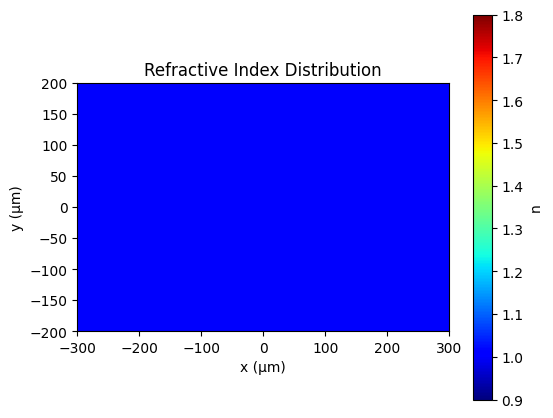

  0%|          | 0/1000 [00:00<?, ?it/s]

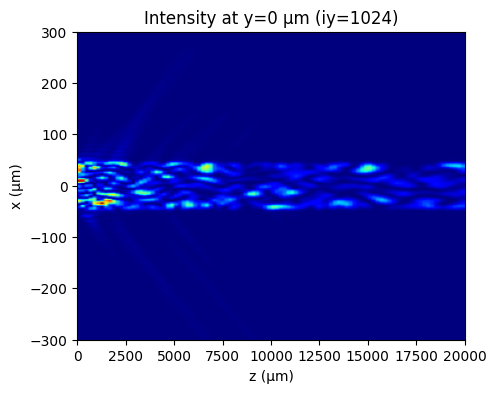

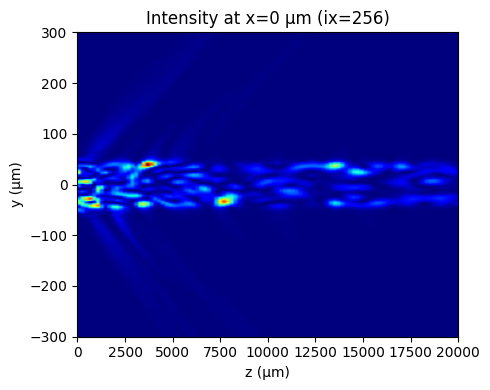

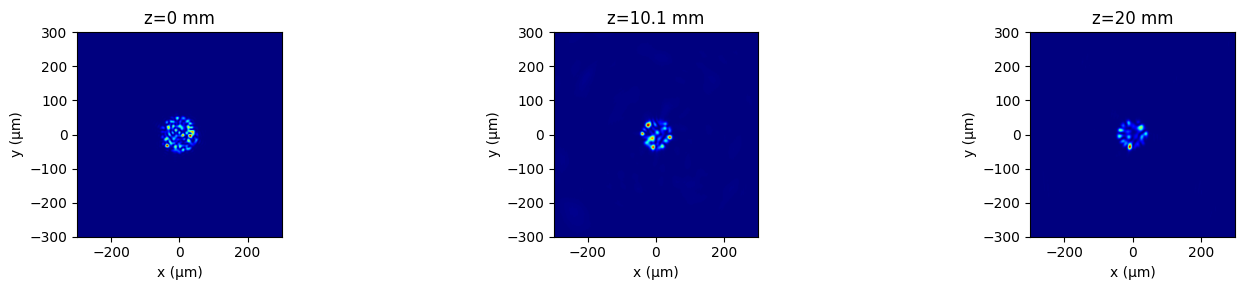

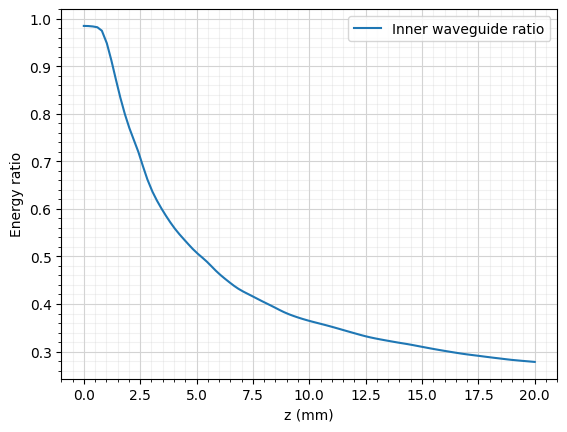

GIF saved to /media/kobayashilab/raid10ssd/akiyamay/BPM_github/p_dn=-1.000000e-03_div=30_WGr=1.000000e-04_waist=5.250000e-05/my_profile_animation.gif



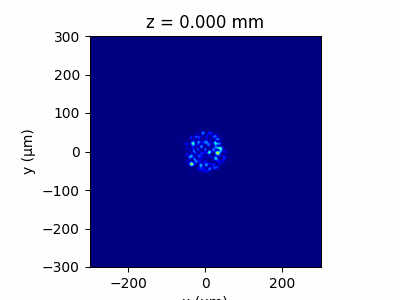

In [24]:
# グローバル変数だったものをNamedTupleにまとめる
LX            = 1000e-6
LY            = 4000e-6
LZ            = 20e-3
WAVELENGTH_P  = 793e-9
WAVELENGTH    = 2e-6
N0            = 1
BEAM_DIAM     = 105e-6
P_OR_S        = 'p'
WGr           = 100e-6
divisions     = 30
d_n           = -1e-3
dx = WAVELENGTH_P * 3
dy = dx
dz = 20e-6

# マスク作成
# X, Y の定義にはBPMSimulation初期化後を使うため、仮置きで後ほど再作成でもOK
# ただし以下のように先に Nx,Ny,X,Y を作っても良い
Nx = 1 << (round(LX/dx) - 1).bit_length()
Ny = 1 << (round(LY/dy) - 1).bit_length()
# x, y
tmpx = (torch.arange(Nx) - Nx//2) * dx
tmpy = (torch.arange(Ny) - Ny//2) * dy
Xg, Yg = torch.meshgrid(tmpx, tmpy, indexing='xy')
MASK_WG = (Xg**2 + Yg**2 < WGr**2)

# NamedTupleにまとめる
sim_params = SimulationParams(
LX=LX,
LY=LY,
LZ=LZ,
wavelength_p=WAVELENGTH_P,
wavelength=WAVELENGTH,
n0=N0,
beam_diameter=BEAM_DIAM,
p_or_s=P_OR_S,
dx=dx,
dy=dy,
dz=dz,
device=device
)
interval=10

# 保存フォルダ名
folder_n= f'{P_OR_S}_dn={d_n:e}_div={divisions}_WGr={WGr:e}_waist={BEAM_DIAM/2:e}'

# シミュレーションオブジェクト
sim = BPMSimulation(sim_params, MASK_WG, save_cfolder=folder_n)

# 導波路形状 (例: 円形 or 三角形)
# c-> circle, t-> triangle
func_dic = {'c': all_in_circle, 't': all_in_triangle}
fsign="c"
func1=func_dic[fsign]

sim.DLW(d_n,
        func1,
        bwx=5e-6,
        bwy=10e-6,
        divisions=divisions,
        base_center=(0, 0),
        radius=50e-6)

sim.set_air_region(150e-6, -1850e-6, 1.0)
sim.plot_refractive_index(x_range=(-300,300), y_range=(-200,200), vmin=1.8)

# 初期ビーム
E0 = sim.create_initial_field(y_center=0)

# BPM実行 (with構文を使う)
with sim.run_bpm(E0, snap_shots=100) as (E_snap, iz_snap, z_snap):
    # 伝搬結果可視化
    sim.plot_field_slices(E_snap, iz_snap, z_snap)

    # エネルギー計算 & プロット
    energy_total, energy_inner = sim.calc_energy(E_snap)
    sim.plot_energy_ratio(energy_total, energy_inner, z_snap)

    # GIF保存と表示
    sim.gif_save_show(E_snap, iz_snap, z_snap, interval=interval)

# withブロックを抜けたので E_snap は自動解放済み
# torch.cuda.empty_cache() は自動呼び出しされている

## d_n依存性

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

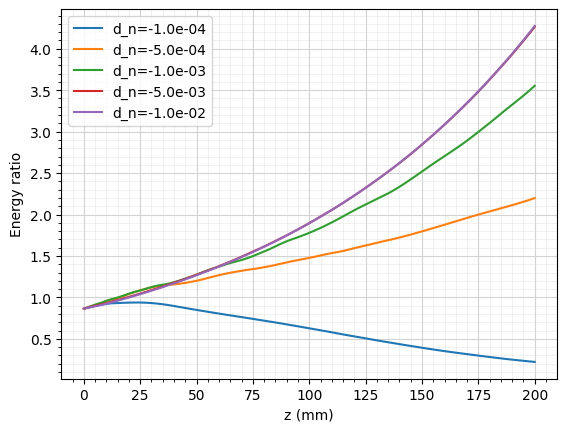

In [23]:
import matplotlib.pyplot as plt


# グローバル変数だったものをNamedTupleにまとめる
LX            = 1000e-6
LY            = 4000e-6
LZ            = 200e-3
WAVELENGTH_P  = 793e-9
WAVELENGTH    = 2e-6
N0            = 1.8073
BEAM_DIAM     = 200e-6
P_OR_S        = 's'
WGr           = 100e-6
divisions     = 30
d_n           = -1e-3
dx = WAVELENGTH_P * 3
dy = dx
dz = 20e-6

# マスク作成
# X, Y の定義にはBPMSimulation初期化後を使うため、仮置きで後ほど再作成でもOK
# ただし以下のように先に Nx,Ny,X,Y を作っても良い
Nx = 1 << (round(LX/dx) - 1).bit_length()
Ny = 1 << (round(LY/dy) - 1).bit_length()
# x, y
tmpx = (torch.arange(Nx) - Nx//2) * dx
tmpy = (torch.arange(Ny) - Ny//2) * dy
Xg, Yg = torch.meshgrid(tmpx, tmpy, indexing='xy')
MASK_WG = (Xg**2 + Yg**2 < WGr**2)

# NamedTupleにまとめる
sim_params = SimulationParams(
LX=LX,
LY=LY,
LZ=LZ,
wavelength_p=WAVELENGTH_P,
wavelength=WAVELENGTH,
n0=N0,
beam_diameter=BEAM_DIAM,
p_or_s=P_OR_S,
dx=dx,
dy=dy,
dz=dz,
device=device
)
interval=10
# d_n を色々変えて試す
d_n_list = [-1e-4, -5e-4, -1e-3, -5e-3, -1e-2]

# すべて同じ図に重ねたいなら、先に作っておく
fig, ax = plt.subplots()

for d_n in d_n_list:
    # 1) シミュレーションオブジェクト作成
    sim = BPMSimulation(sim_params, MASK_WG, save_cfolder="test_dn")

    # 2) 屈折率書き込み (DLW)
    #    例として三角形や円の関数は共通とする（func1 など）
    sim.DLW(d_n,
            func1,
            bwx=5e-6,
            bwy=10e-6,
            divisions=divisions,
            base_center=(0, 0),
            radius=WGr)

    # 例: 空気領域の設定が必要ならここで
    sim.set_air_region(150e-6, -1850e-6, 1.0)

    # 3) 初期ビーム生成
    E0 = sim.create_initial_field(y_center=0)

    # 4) BPM 実行 (with構文：メモリ解放を自動)
    with sim.run_bpm(E0, snap_shots=100) as (E_snap, iz_snap, z_snap):

        # 5) エネルギーの計算
        energy_total, energy_inner = sim.calc_energy(E_snap)

        # 6) エネルギー比をプロット
        #    plot_energy_ratio 内部で新たに figure を作らず、
        #    既存の ax に重ね描きしたいならメソッドを少し改造して使う。
        ratio_inner = (energy_inner / energy_total[0]).cpu().numpy()
        z_vals_mm   = (z_snap * 1e3).cpu().numpy()

        # 今回は自分で直接プロット
        ax.plot(z_vals_mm, ratio_inner, label=f"d_n={d_n:.1e}")

ax.set_xlabel("z (mm)")
ax.set_ylabel("Energy ratio")
ax.minorticks_on()
ax.grid(which="both", color="lightgray")
ax.grid(which="minor", alpha=0.3)
ax.legend()
plt.show()


## 空気中のMM伝搬での検証

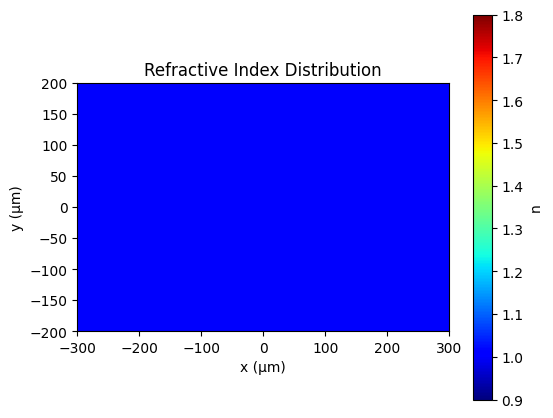

  0%|          | 0/5000 [00:00<?, ?it/s]

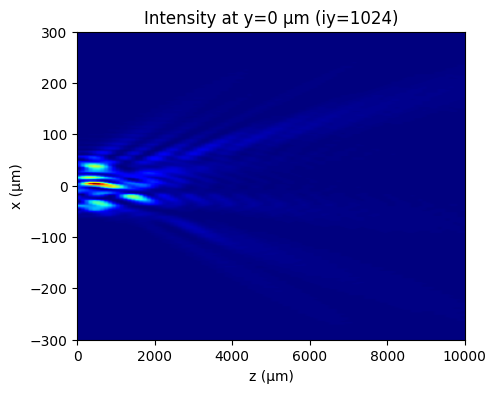

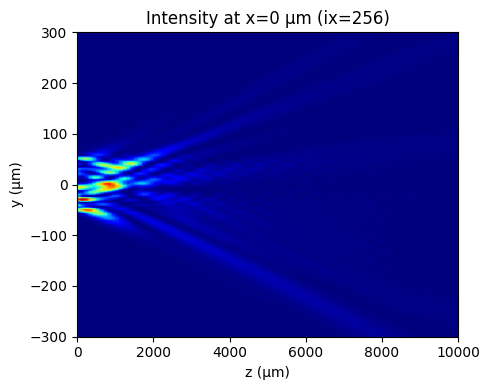

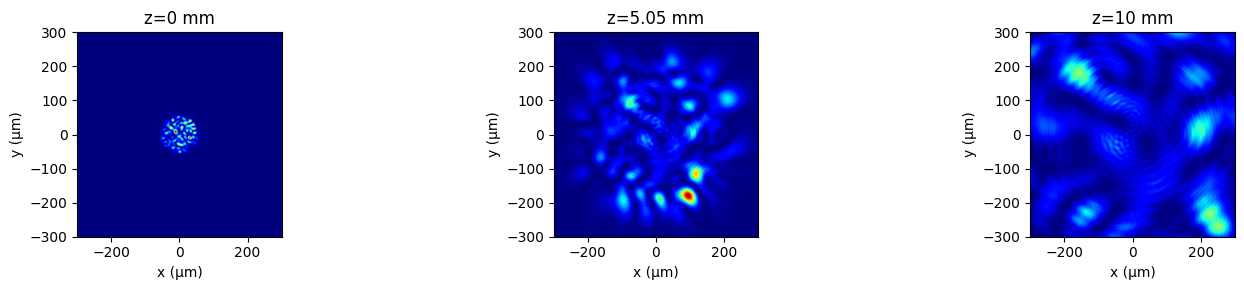

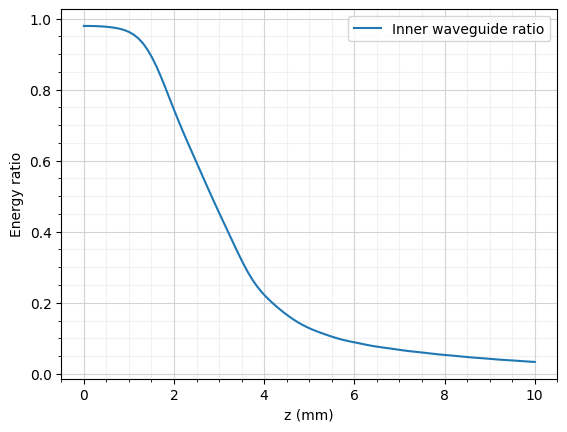

GIF saved to /media/kobayashilab/raid10ssd/akiyamay/BPM_github/p_dn=-1.000000e-03_div=30_WGr=1.000000e-04_waist=5.250000e-05/my_profile_animation.gif



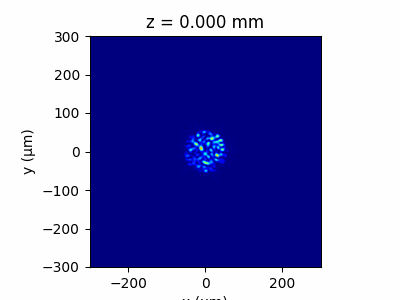

In [28]:
# グローバル変数だったものをNamedTupleにまとめる
LX            = 1000e-6
LY            = 4000e-6
LZ            = 10e-3
WAVELENGTH_P  = 793e-9
WAVELENGTH    = 2e-6
N0            = 1
BEAM_DIAM     = 105e-6
P_OR_S        = 'p'
WGr           = 100e-6
divisions     = 30
d_n           = -1e-3
dx = WAVELENGTH_P * 3
dy = dx
dz = 2e-6

# マスク作成
# X, Y の定義にはBPMSimulation初期化後を使うため、仮置きで後ほど再作成でもOK
# ただし以下のように先に Nx,Ny,X,Y を作っても良い
Nx = 1 << (round(LX/dx) - 1).bit_length()
Ny = 1 << (round(LY/dy) - 1).bit_length()
# x, y
tmpx = (torch.arange(Nx) - Nx//2) * dx
tmpy = (torch.arange(Ny) - Ny//2) * dy
Xg, Yg = torch.meshgrid(tmpx, tmpy, indexing='xy')
MASK_WG = (Xg**2 + Yg**2 < WGr**2)

# NamedTupleにまとめる
sim_params = SimulationParams(
LX=LX,
LY=LY,
LZ=LZ,
wavelength_p=WAVELENGTH_P,
wavelength=WAVELENGTH,
n0=N0,
beam_diameter=BEAM_DIAM,
p_or_s=P_OR_S,
dx=dx,
dy=dy,
dz=dz,
device=device
)
interval=10

# 保存フォルダ名
folder_n= f'{P_OR_S}_dn={d_n:e}_div={divisions}_WGr={WGr:e}_waist={BEAM_DIAM/2:e}'

# シミュレーションオブジェクト
sim = BPMSimulation(sim_params, MASK_WG, save_cfolder=folder_n)

# 導波路形状 (例: 円形 or 三角形)
# c-> circle, t-> triangle
func_dic = {'c': all_in_circle, 't': all_in_triangle}
fsign="c"
func1=func_dic[fsign]

sim.set_air_region(150e-6, -1850e-6, 1.0)
sim.plot_refractive_index(x_range=(-300,300), y_range=(-200,200), vmin=1.8)

# 初期ビーム
E0 = sim.create_initial_field(y_center=0)

# BPM実行 (with構文を使う)
with sim.run_bpm(E0, snap_shots=100) as (E_snap, iz_snap, z_snap):
    # 伝搬結果可視化
    sim.plot_field_slices(E_snap, iz_snap, z_snap)

    # エネルギー計算 & プロット
    energy_total, energy_inner = sim.calc_energy(E_snap)
    sim.plot_energy_ratio(energy_total, energy_inner, z_snap)

    # GIF保存と表示
    sim.gif_save_show(E_snap, iz_snap, z_snap, interval=interval)

# withブロックを抜けたので E_snap は自動解放済み
# torch.cuda.empty_cache() は自動呼び出しされている

## sの半径依存性

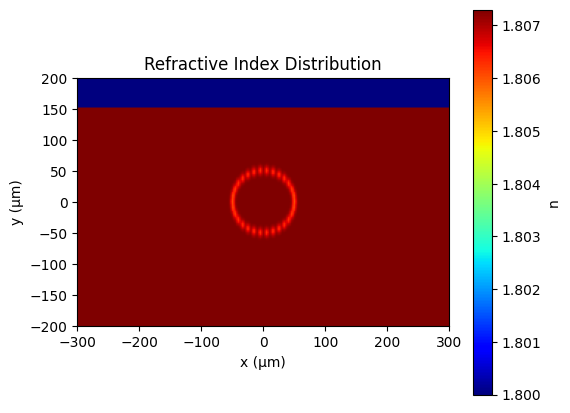

  0%|          | 0/10000 [00:00<?, ?it/s]

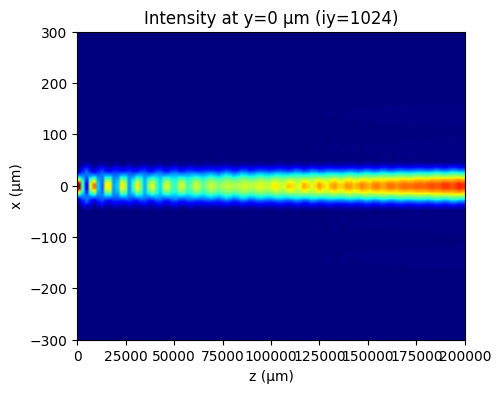

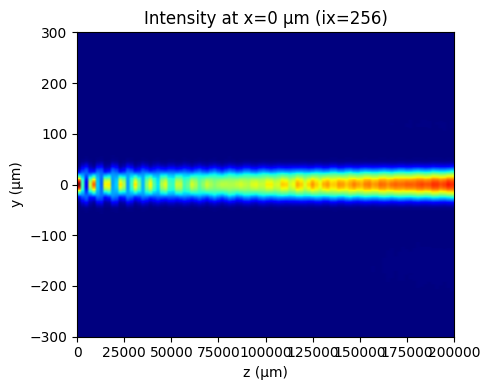

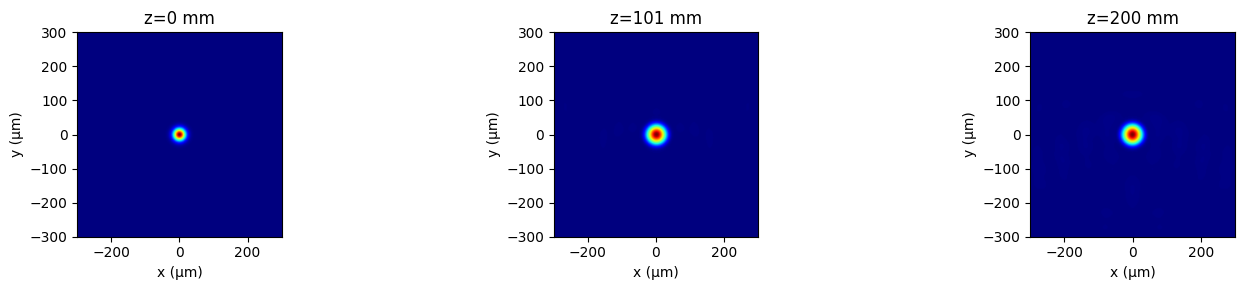

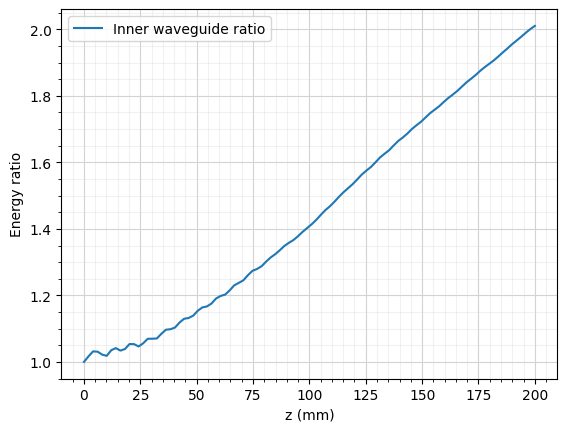

GIF saved to /media/kobayashilab/raid10ssd/akiyamay/BPM_github/p_dn=-1.000000e-03_div=30_WGr=1.000000e-04_waist=2.500000e-05/my_profile_animation.gif



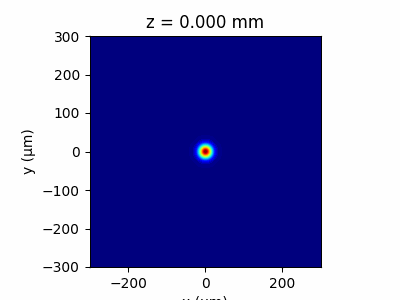

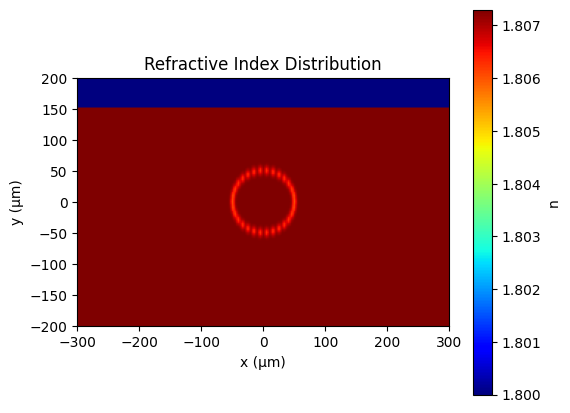

  0%|          | 0/10000 [00:00<?, ?it/s]

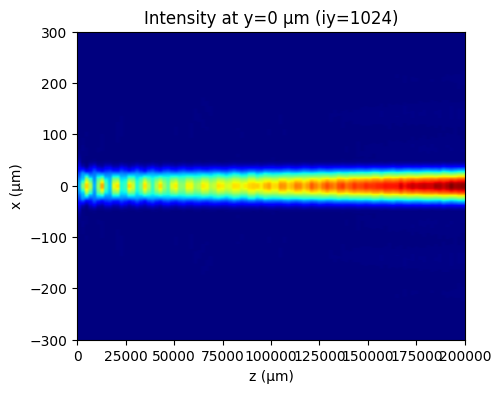

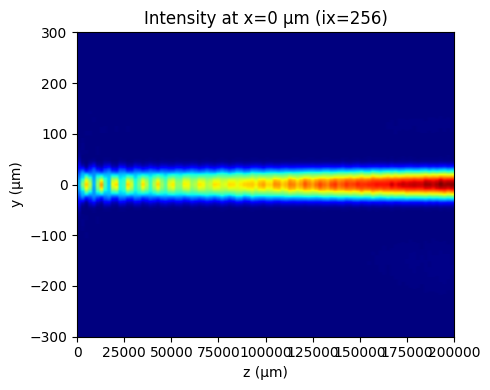

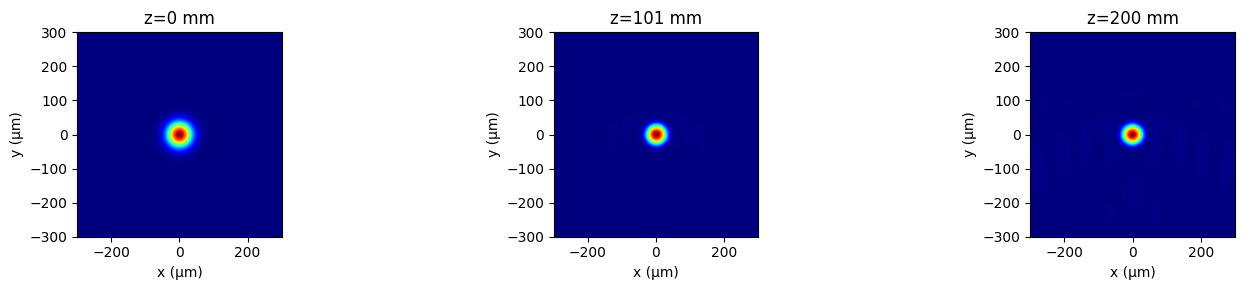

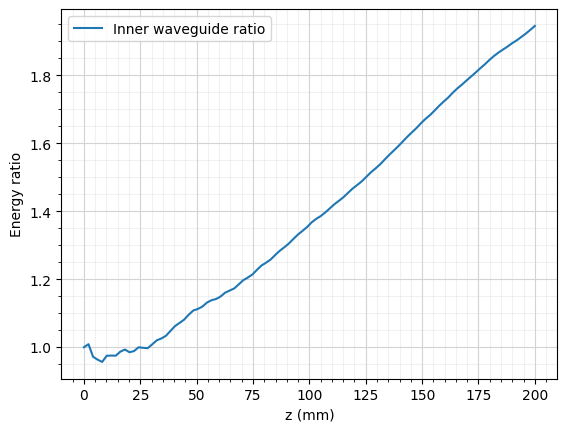

GIF saved to /media/kobayashilab/raid10ssd/akiyamay/BPM_github/p_dn=-1.000000e-03_div=30_WGr=1.000000e-04_waist=5.000000e-05/my_profile_animation.gif



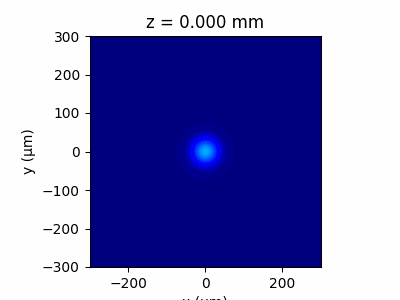

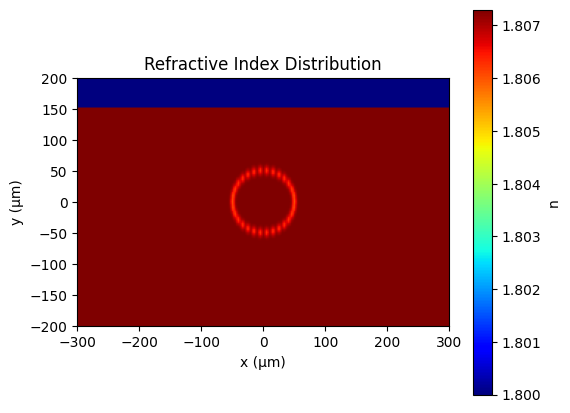

  0%|          | 0/10000 [00:00<?, ?it/s]

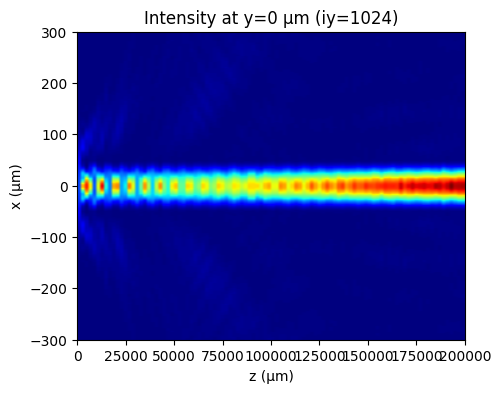

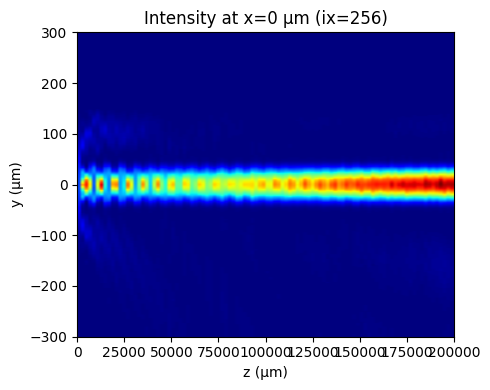

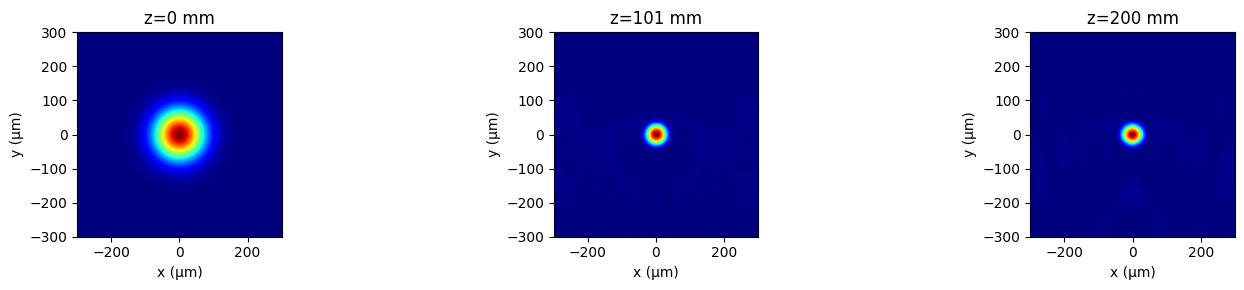

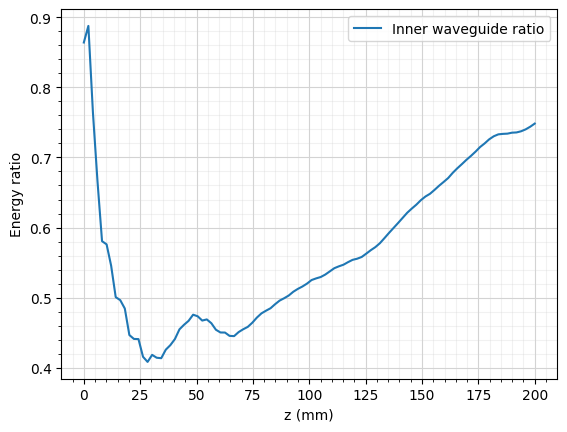

GIF saved to /media/kobayashilab/raid10ssd/akiyamay/BPM_github/p_dn=-1.000000e-03_div=30_WGr=1.000000e-04_waist=1.000000e-04/my_profile_animation.gif



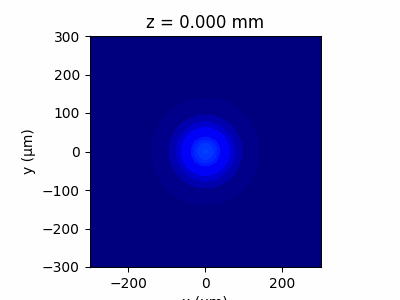

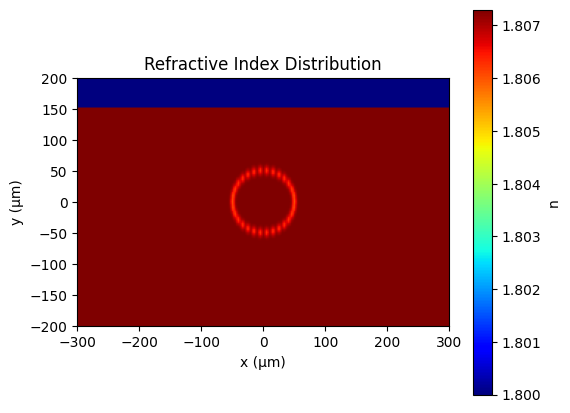

  0%|          | 0/10000 [00:00<?, ?it/s]

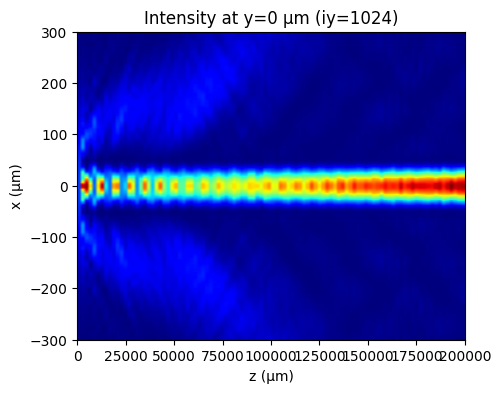

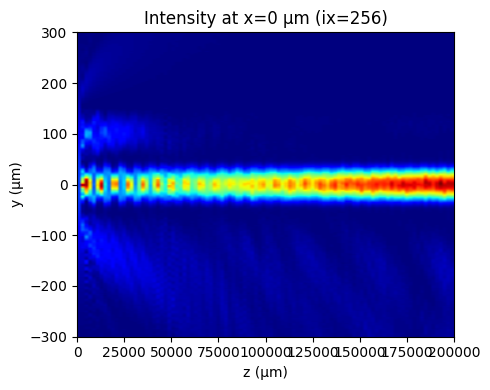

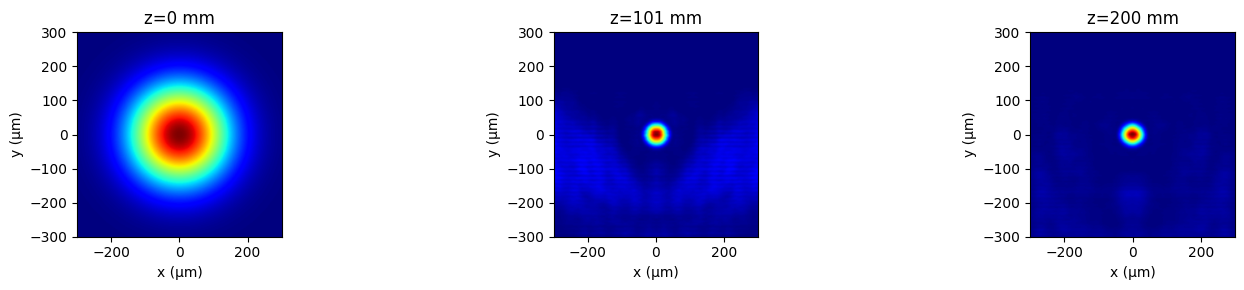

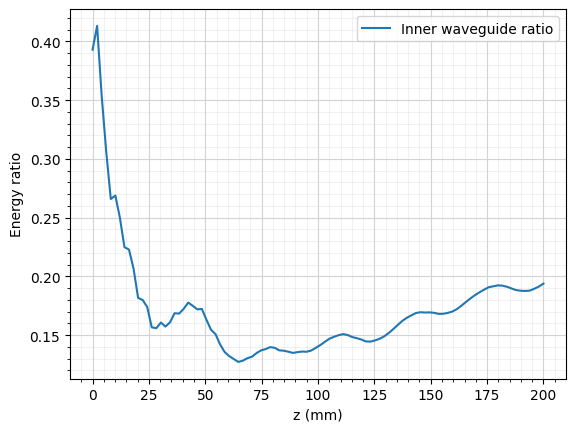

GIF saved to /media/kobayashilab/raid10ssd/akiyamay/BPM_github/p_dn=-1.000000e-03_div=30_WGr=1.000000e-04_waist=2.000000e-04/my_profile_animation.gif



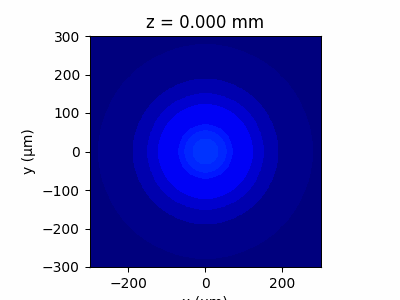

In [17]:
# グローバル変数だったものをNamedTupleにまとめる
P_OR_S        = 'p'
WGr           = 100e-6
divisions     = 30
d_n           = -1e-3
dx = 793e-9 * 3
dy = dx
dz = 20e-6
BEAM_DIAM= 100e-6

# マスク作成
# X, Y の定義にはBPMSimulation初期化後を使うため、仮置きで後ほど再作成でもOK
# ただし以下のように先に Nx,Ny,X,Y を作っても良い
Nx = 1 << (round(LX/dx) - 1).bit_length()
Ny = 1 << (round(LY/dy) - 1).bit_length()
# x, y
tmpx = (torch.arange(Nx) - Nx//2) * dx
tmpy = (torch.arange(Ny) - Ny//2) * dy
Xg, Yg = torch.meshgrid(tmpx, tmpy, indexing='xy')
MASK_WG = (Xg**2 + Yg**2 < WGr**2)
for BEAM_DIAM in [50e-6, 100e-6, 200e-6, 400e-6]:
    sim_params = SimulationParams(
        LX=1000e-6,
        LY=4000e-6,
        LZ=200e-3,
        wavelength_p=793e-9,
        wavelength=2e-6,
        n0=1.8073,
        beam_diameter=BEAM_DIAM,
        p_or_s='s',
        dx=dx,
        dy=dy,
        dz=dz,
        device=device
    )
    interval=10

    # 保存フォルダ名
    folder_n= f'{P_OR_S}_dn={d_n:e}_div={divisions}_WGr={WGr:e}_waist={BEAM_DIAM/2:e}'

    # シミュレーションオブジェクト
    sim = BPMSimulation(sim_params, MASK_WG, save_cfolder=folder_n)

    # 導波路形状 (例: 円形 or 三角形)
    # c-> circle, t-> triangle
    func_dic = {'c': all_in_circle, 't': all_in_triangle}
    fsign="c"
    func1=func_dic[fsign]

    sim.DLW(d_n,
            func1,
            bwx=5e-6,
            bwy=10e-6,
            divisions=divisions,
            base_center=(0, 0),
            radius=50e-6)

    sim.set_air_region(150e-6, -1850e-6, 1.0)
    sim.plot_refractive_index(x_range=(-300,300), y_range=(-200,200), vmin=1.8)

    # 初期ビーム
    E0 = sim.create_initial_field(y_center=0)

    # BPM実行 (with構文を使う)
    with sim.run_bpm(E0, snap_shots=100) as (E_snap, iz_snap, z_snap):
        # 伝搬結果可視化
        sim.plot_field_slices(E_snap, iz_snap, z_snap)

        # エネルギー計算 & プロット
        energy_total, energy_inner = sim.calc_energy(E_snap)
        sim.plot_energy_ratio(energy_total, energy_inner, z_snap)

        # GIF保存と表示
        sim.gif_save_show(E_snap, iz_snap, z_snap, interval=interval)

    # withブロックを抜けたので E_snap は自動解放済み
    # torch.cuda.empty_cache() は自動呼び出しされている



In [9]:
import torch
import gc

def show_cuda_tensor_memory():
    total_memory = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                size_bytes = obj.element_size() * obj.nelement()
                total_memory += size_bytes
                print(f"Tensor: {type(obj)}, shape: {tuple(obj.shape)}, size: {size_bytes / 1024:.2f} KB")
        except Exception as e:
            pass
    print(f"Total CUDA tensor memory: {total_memory / 1024 / 1024:.2f} MB")

show_cuda_tensor_memory()

Tensor: <class 'torch.Tensor'>, shape: (512,), size: 2.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048,), size: 8.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048, 512), size: 4096.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048, 512), size: 4096.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048, 512), size: 16384.00 KB
Tensor: <class 'torch.Tensor'>, shape: (512,), size: 2.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048,), size: 8.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048, 512), size: 4096.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048, 512), size: 4096.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048, 512), size: 16384.00 KB
Tensor: <class 'torch.Tensor'>, shape: (2048, 512), size: 16384.00 KB
Total CUDA tensor memory: 64.02 MB


/home/kobayashilab/.pyenv/versions/3.13.1/lib/python3.13/site-packages/torch/__init__.py:1021: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
